In [2]:
import tqdm
import random

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt


class HopfieldNetwork:
    def __init__(self,network_shape=None):
        assert isinstance(network_shape,int)
        self.input_shape = network_shape

    def train(self,_data):

        #rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        data = np.copy(_data)

        weights = np.zeros((self.input_shape,self.input_shape)).astype(float)

        for datum in tqdm.tqdm(data):
            #assert isinstance(datum,np.ndarray)
            weights = np.add(weights,np.outer(datum.T, datum))
        
        np.fill_diagonal(weights,0.0)
        self.weights = weights/len(data)

    def predict(self,X,max_iter=10, threshold=0):
        # Start states at zero
        neuron_init_state = np.copy(X).astype(float)

        n_iters = 0
        while n_iters<max_iter:

            # Updating all neurons in random order
            # neuron_idxs = list(range(self.input_shape))
            # random.shuffle(neuron_idxs)
            # for neuron_idx in neuron_idxs:
            #     neuron_init_state[neuron_idx] = np.sign(self.weights[neuron_idx].T@neuron_init_state)

            # Selecting a random neuron
            neuron_idx = random.randint(0,self.input_shape-1)
            neuron_init_state[neuron_idx] = np.sign(self.weights[neuron_idx]@neuron_init_state)
            
            n_iters+=1

        return neuron_init_state


    def energy(self,state):
        return -state@(self.weights.T@state)/2


In [3]:
# Testing on a simple 3 neuron network
m1 = np.array([1,-1,1])
m2 = np.array([-1,-1,1])

network = HopfieldNetwork(3)
network.train([m1,m2])
network.predict(np.array([1,-1,-1]))

100%|██████████| 2/2 [00:00<00:00, 8656.97it/s]


array([ 0.,  1., -1.])

In [4]:
network.weights

array([[ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0., -1.,  0.]])

In [5]:
from THopfield import HopfieldNetwork2
import numpy as np

network2 = HopfieldNetwork2()

m1 = np.array([1,-1,1])
m2 = np.array([-1,1,1])

network2.train_weights([m1])

Start to train weights...


100%|██████████| 1/1 [00:00<00:00, 9799.78it/s]


In [6]:
network2.predict([np.array([-1,-1,1])])

Start to predict...


100%|██████████| 1/1 [00:00<00:00, 3986.98it/s]


[array([ 1., -1.,  1.])]

In [7]:
network.weights

array([[ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0., -1.,  0.]])

In [8]:
import pickle

with open('./data/mnist-data.pickle','rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
X_train_flt = X_train.reshape(60000,-1).astype(float)/255
X_train_flt = X_train_flt - 0.5
X_train_flt = X_train_flt.astype(float)
X_train_flt = np.where(X_train_flt<0,-1.0,1.0)
X_train_flt.shape

(60000, 784)

In [11]:
np.unique(X_train_flt.ravel())

array([-1.,  1.])

In [12]:
X_train_flt[:10].shape

(10, 784)

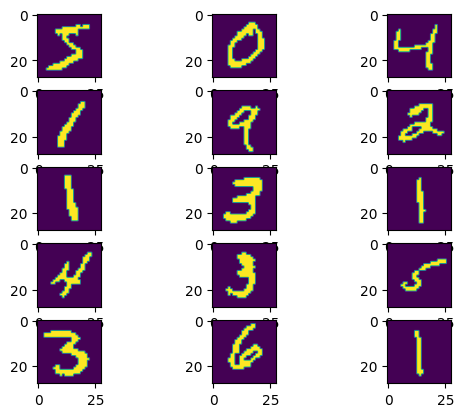

In [13]:
import math

imgs = X_train_flt[:15]
n_cols = 3
n_rows = math.ceil(len(imgs)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols)

for imgs,axis in zip(imgs,axes.flatten()):
    axis.imshow(imgs.reshape(28,28))

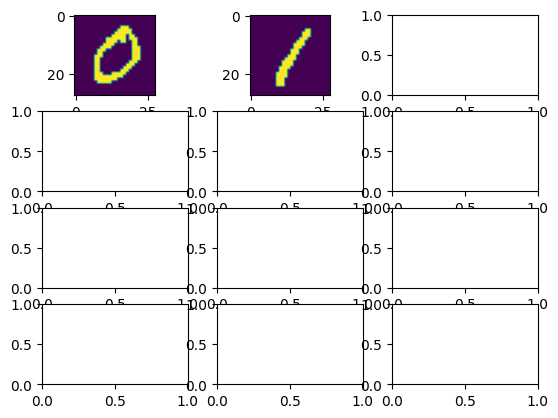

In [14]:
import math

imgs = X_train_flt[:10]
n_cols = 3
n_rows = math.ceil(len(imgs)/n_cols)

fig,axes = plt.subplots(n_rows,n_cols)

train_imgs = X_train_flt[[1,3]]
#train_imgs = X_train_flt[[1,3,5]]
#train_imgs = X_train_flt[[1,3,5,7]]
#train_imgs = X_train_flt[[1,3,5,7,9]]
#train_imgs = X_train_flt[[1,3,5,7,9,0]]

for img,axis in zip(train_imgs,axes.flatten()):
    axis.imshow(img.reshape(28,28))

In [15]:
n_neurons = X_train_flt.shape[1]
print(f'Training Hopfield net with {n_neurons} neurons')
network = HopfieldNetwork(n_neurons)
network.train(train_imgs)

Training Hopfield net with 784 neurons


100%|██████████| 2/2 [00:00<00:00, 392.45it/s]


In [16]:
def noisify(array,sd=0.5):
    array_shape = array.shape
    noise = np.random.normal(0,sd,size=array_shape)
    return np.sign(array+noise)

In [17]:
def plot_reconstruction(test_img_idx):
    fig,axes = plt.subplots(1,5,figsize=[20,5])

    mnist_img = train_imgs[test_img_idx]
    mnist_img_noised = noisify(mnist_img,sd=2.0)

    axes[0].imshow(np.sign(mnist_img.reshape(28,28)))
    axes[0].set_title('Original')

    axes[1].imshow(np.sign(mnist_img_noised.reshape(28,28)))
    axes[1].set_title('With Noise')


    p = network.predict(mnist_img_noised,max_iter=100)
    axes[2].imshow(p.reshape(28,28))
    axes[2].set_title(f'Recon - no iters: 100, E: {network.energy(p):0.0f}')

    p = network.predict(mnist_img_noised,max_iter=1000)
    axes[3].imshow(p.reshape(28,28))
    axes[3].set_title(f'Recon - no iters: 1000, E: {network.energy(p):0.0f}')


    p = network.predict(mnist_img_noised,max_iter=10000)
    axes[4].imshow(p.reshape(28,28))
    axes[4].set_title(f'Recon - no iters: 10000, E: {network.energy(p):0.0f}')

    plt.show()

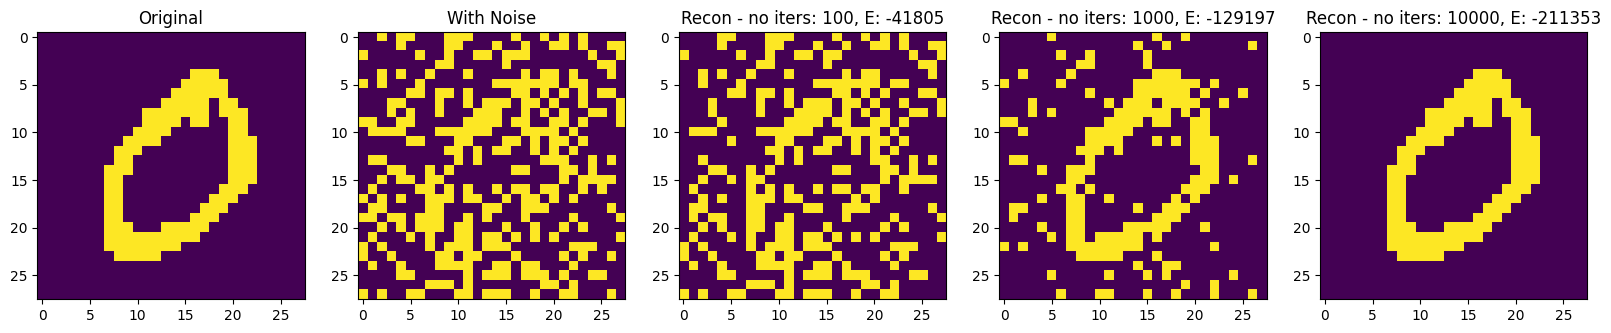

In [18]:
plot_reconstruction(0)

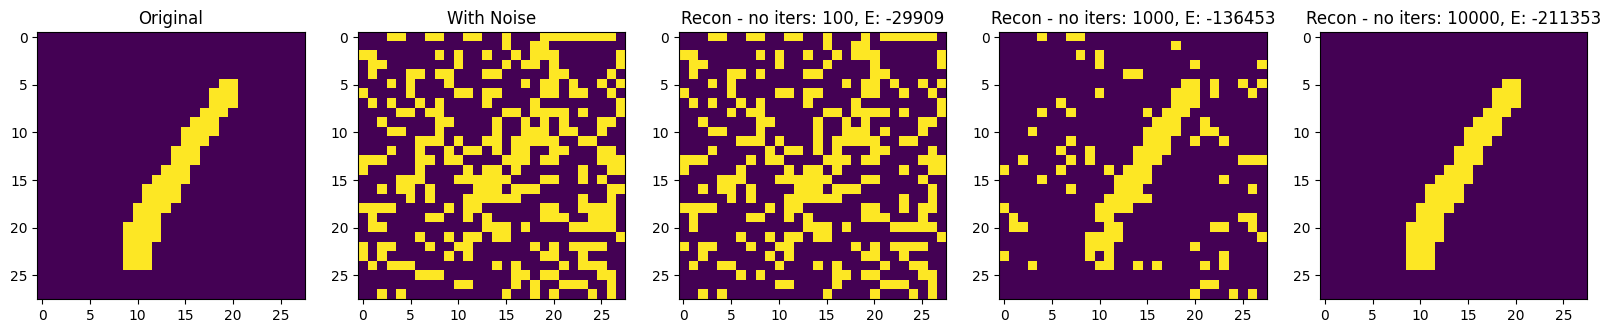

In [19]:
plot_reconstruction(1)

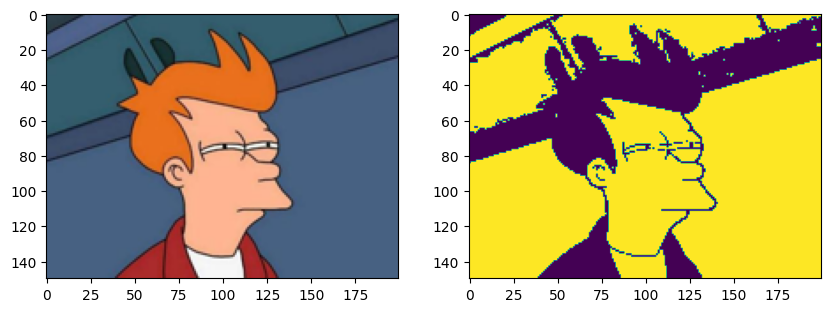

In [28]:
from PIL import Image
import numpy as np
fry_img = Image.open('./data/Futurama-Fry.jpg')
fry_img.thumbnail((200,200))
fry_img = np.asarray(fry_img)

fig,axes = plt.subplots(1,2,figsize=[10,5])

axes[0].imshow(fry_img)

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.15 * r + 0.4 * g + 0.8 * b

    gray = gray - 255/2
    return gray
axes[0].imshow(fry_img)

fry_img = np.sign(rgb2gray(fry_img))

axes[1].imshow(fry_img)
plt.show()

In [29]:
fry_img_seq = fry_img.ravel()
n_neurons = fry_img_seq.__len__()
print(f'Training Hopfield net with {n_neurons} neurons')
network = HopfieldNetwork(n_neurons)
network.train([fry_img_seq])

Training Hopfield net with 30000 neurons


100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


In [30]:
fry_img.shape

(150, 200)

In [31]:
fry_img_noised = noisify(fry_img_seq,sd=2.0)

In [32]:
fry_img.shape

(150, 200)

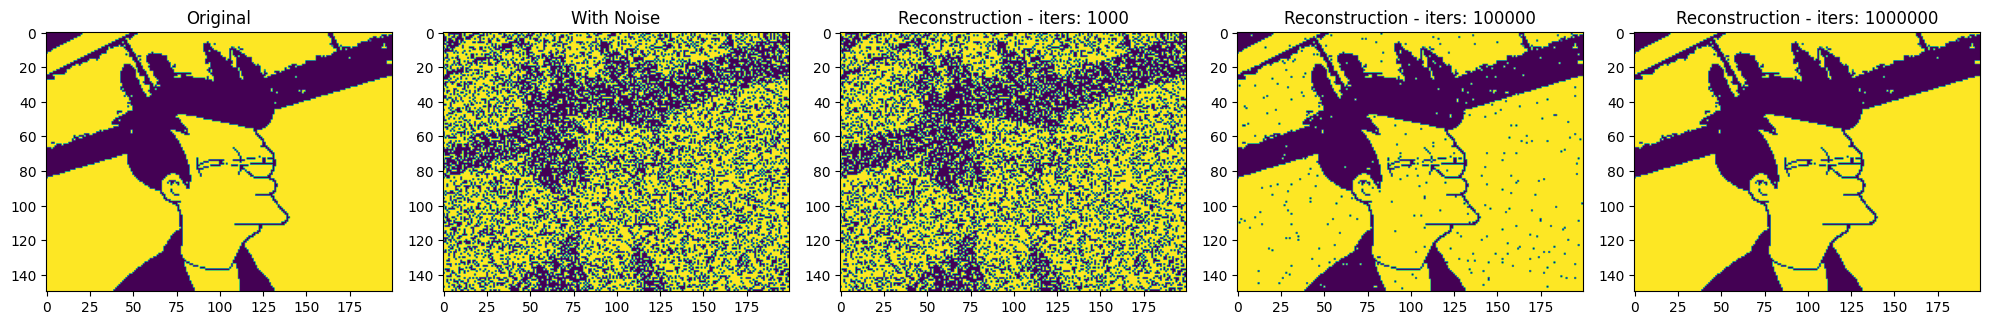

In [39]:
fig,axes = plt.subplots(1,5,figsize=[20,5])

fry_img_noised = noisify(fry_img_seq,sd=2.0)

axes[0].imshow(np.sign(fry_img_seq.reshape(*fry_img.shape)))
axes[0].set_title('Original')

axes[1].imshow(np.sign(fry_img_noised.reshape(*fry_img.shape)))
axes[1].set_title('With Noise')

p = network.predict(fry_img_noised,max_iter=1000)
axes[2].imshow(p.reshape(*fry_img.shape))
axes[2].set_title('Reconstruction - iters: 1000')

p = network.predict(fry_img_noised,max_iter=100000)
axes[3].imshow(p.reshape(*fry_img.shape))
axes[3].set_title('Reconstruction - iters: 100000')

p = network.predict(fry_img_noised,max_iter=1000000)
axes[4].imshow(p.reshape(*fry_img.shape))
axes[4].set_title('Reconstruction - iters: 1000000')

plt.tight_layout()
plt.savefig('noisy-reconstruction.png',dpi=150
            )
plt.show()

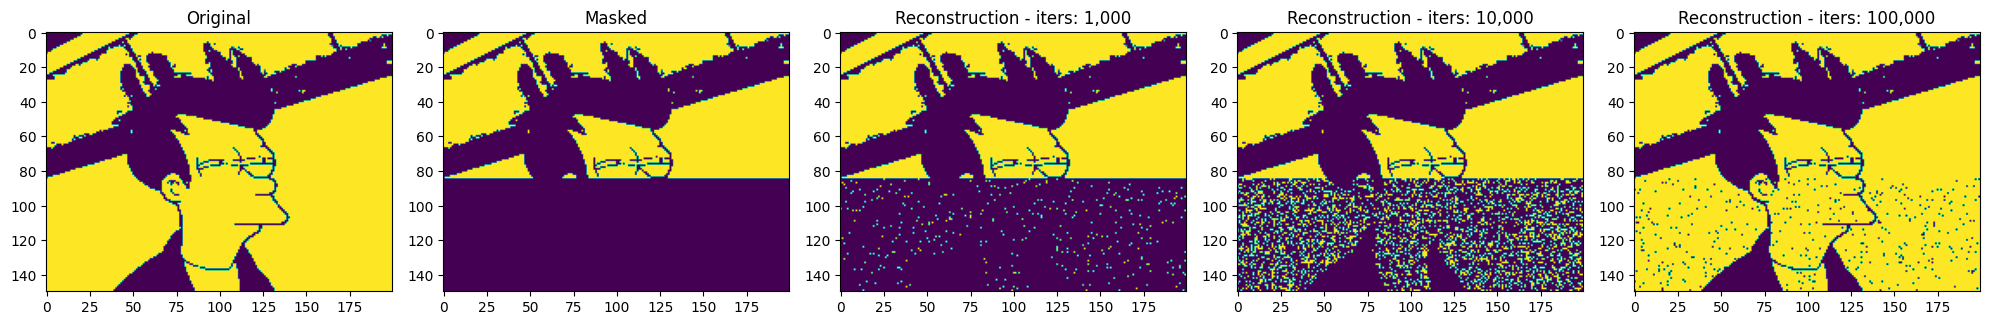

In [40]:
fig,axes = plt.subplots(1,5,figsize=[20,5])

fry_img_masked = fry_img_seq.reshape(150,200)
slice_size = 65
fry_img_masked = np.concatenate([fry_img_masked[:150-slice_size,:],
                           np.full((slice_size,200), -1)],axis=0).ravel()

axes[0].imshow(np.sign(fry_img_seq.reshape(*fry_img.shape)))
axes[0].set_title('Original')

axes[1].imshow(np.sign(fry_img_masked.reshape(*fry_img.shape)))
axes[1].set_title('Masked')

p = network.predict(fry_img_masked,max_iter=1000)
axes[2].imshow(p.reshape(*fry_img.shape))
axes[2].set_title('Reconstruction - iters: 1,000')

p = network.predict(fry_img_masked,max_iter=10000)
axes[3].imshow(p.reshape(*fry_img.shape))
axes[3].set_title('Reconstruction - iters: 10,000')

p = network.predict(fry_img_masked,max_iter=100000)
axes[4].imshow(p.reshape(*fry_img.shape))
axes[4].set_title('Reconstruction - iters: 100,000')

plt.tight_layout()
plt.savefig('masked-reconstruction.png',dpi=150
            )
plt.show()

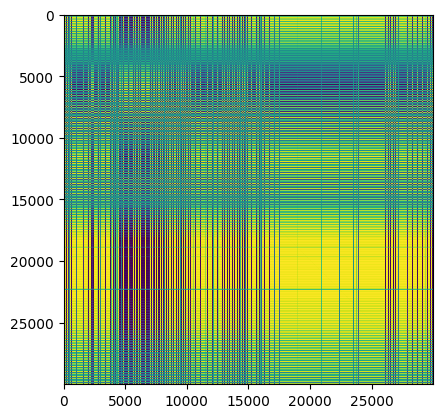

In [ ]:
plt.imshow(network.weights)